# Phase 1: Data Exploration & Preprocessing

**Project:** AI-Powered Pneumonia Detection from Chest X-Rays  
**Author:** Georgios Kitsakis  
**Date:** 2025-10-27

## Objectives
1. Load and explore the Chest X-Ray dataset
2. Visualize sample images from both classes (Normal vs Pneumonia)
3. Analyze class distribution and data balance
4. Implement preprocessing pipeline (resize, normalize)
5. Apply data augmentation techniques
6. Create PyTorch DataLoaders for training

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.8.0+cpu
CUDA Available: False


## 2. Dataset Overview

The dataset should be organized as:
```
data/
├── train/
│   ├── NORMAL/
│   └── PNEUMONIA/
├── test/
│   ├── NORMAL/
│   └── PNEUMONIA/
└── val/
    ├── NORMAL/
    └── PNEUMONIA/
```

In [2]:
# Define dataset paths
BASE_DIR = os.path.join('..', 'data')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VAL_DIR = os.path.join(BASE_DIR, 'val')

# Check if data directories exist
for dir_path in [TRAIN_DIR, TEST_DIR, VAL_DIR]:
    if os.path.exists(dir_path):
        print(f"✓ {dir_path} exists")
    else:
        print(f"✗ {dir_path} NOT FOUND - Please download and extract the dataset")

✓ ..\data\train exists
✓ ..\data\test exists
✓ ..\data\val exists


## 3. Explore Dataset Structure

In [3]:
def count_images(directory):
    """Count images in each class folder"""
    counts = {}
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(directory, class_name)
        if os.path.exists(class_path):
            counts[class_name] = len([f for f in os.listdir(class_path) 
                                      if f.endswith(('.jpeg', '.jpg', '.png'))])
        else:
            counts[class_name] = 0
    return counts

# Count images in each split
train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)
val_counts = count_images(VAL_DIR)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Train': train_counts,
    'Test': test_counts,
    'Validation': val_counts
})

summary_df.loc['Total'] = summary_df.sum()

print("\n=== Dataset Summary ===")
print(summary_df)
print(f"\nTotal Images: {summary_df.loc['Total'].sum():.0f}")


=== Dataset Summary ===
           Train  Test  Validation
NORMAL      1341   234           8
PNEUMONIA   3875   390           8
Total       5216   624          16

Total Images: 5856


## 4. Visualize Class Distribution

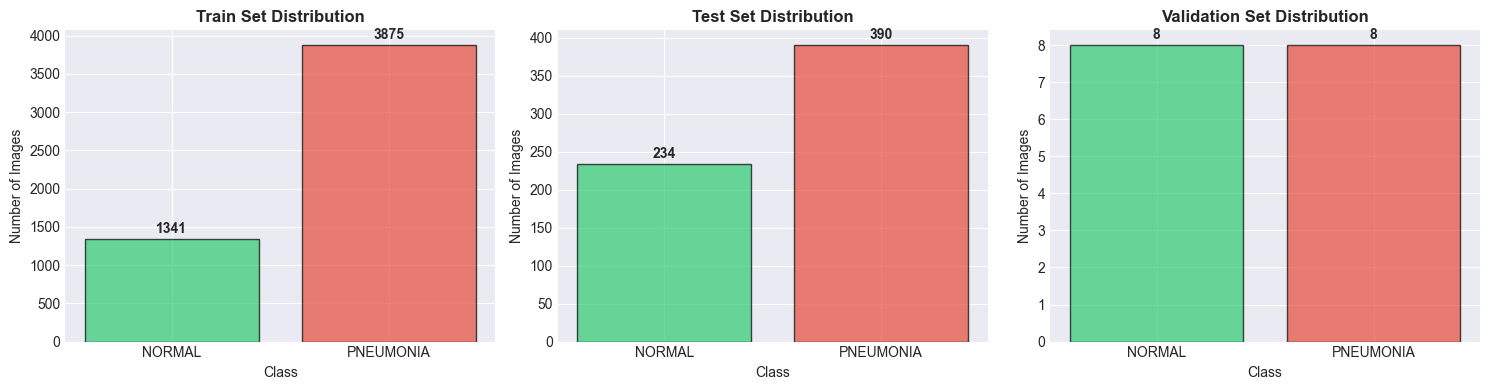


Class Imbalance in Training Set:
  NORMAL: 25.7%
  PNEUMONIA: 74.3%
  Imbalance Ratio: 2.89:1


In [4]:
# Plot class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
splits = ['Train', 'Test', 'Validation']
data = [train_counts, test_counts, val_counts]

for ax, split, counts in zip(axes, splits, data):
    classes = list(counts.keys())
    values = list(counts.values())
    colors = ['#2ecc71', '#e74c3c']  # Green for Normal, Red for Pneumonia
    
    ax.bar(classes, values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_title(f'{split} Set Distribution', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Images')
    ax.set_xlabel('Class')
    
    # Add value labels on bars
    for i, v in enumerate(values):
        ax.text(i, v + max(values)*0.02, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate class imbalance ratio
pneumonia_ratio = train_counts['PNEUMONIA'] / (train_counts['NORMAL'] + train_counts['PNEUMONIA'])
print(f"\nClass Imbalance in Training Set:")
print(f"  NORMAL: {(1-pneumonia_ratio)*100:.1f}%")
print(f"  PNEUMONIA: {pneumonia_ratio*100:.1f}%")
print(f"  Imbalance Ratio: {train_counts['PNEUMONIA']/train_counts['NORMAL']:.2f}:1")

## 5. Visualize Sample Images

Sample X-Ray Images:


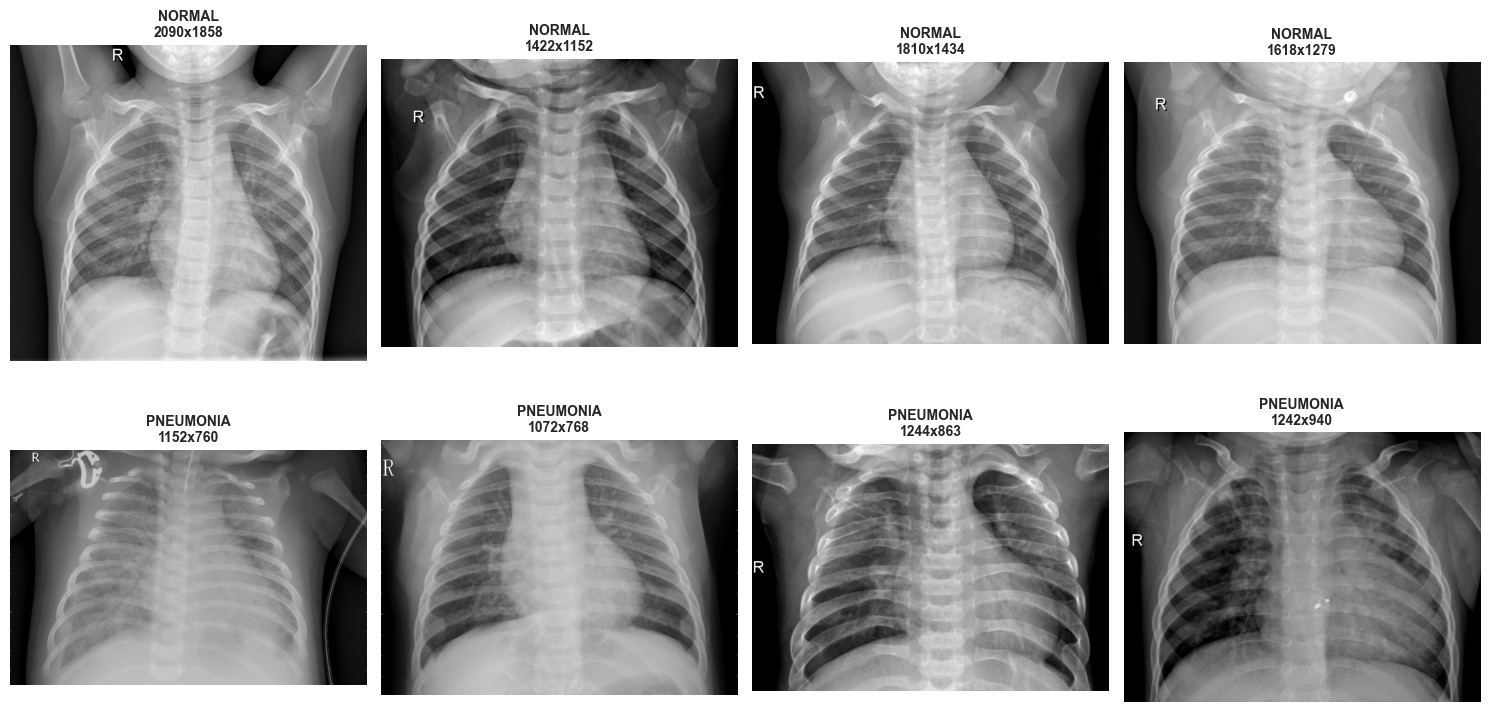

In [5]:
def display_sample_images(directory, num_samples=3):
    """Display sample images from each class"""
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    for idx, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpeg', '.jpg', '.png'))][:num_samples]
        
        for i, img_file in enumerate(image_files):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            
            axes[idx, i].imshow(img, cmap='gray')
            axes[idx, i].axis('off')
            axes[idx, i].set_title(f'{class_name}\n{img.size[0]}x{img.size[1]}', 
                                  fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../reports/sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Sample X-Ray Images:")
display_sample_images(TRAIN_DIR, num_samples=4)

## 6. Analyze Image Properties


Image Dimensions Analysis (sample of 400 images):
  Width  - Min: 502, Max: 2538, Mean: 1442
  Height - Min: 307, Max: 2066, Mean: 1086


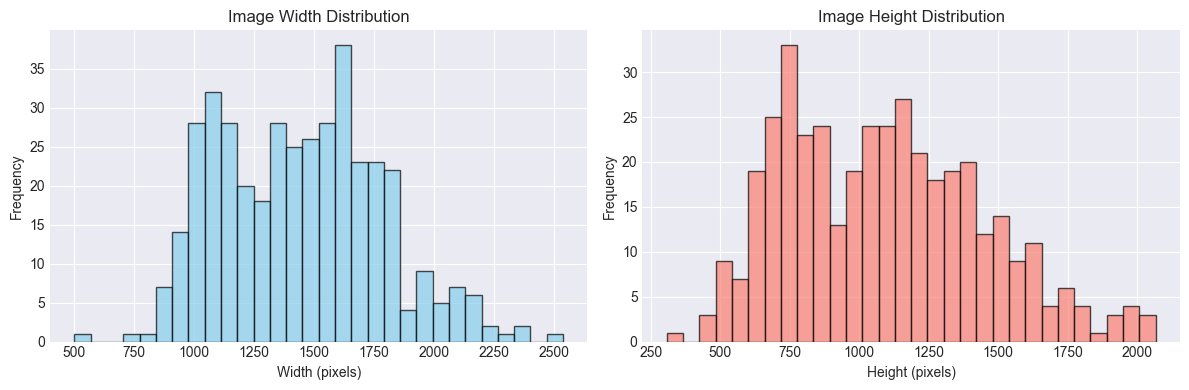

In [6]:
def analyze_image_properties(directory, sample_size=100):
    """Analyze dimensions and properties of images"""
    widths, heights = [], []
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpeg', '.jpg', '.png'))][:sample_size]
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            widths.append(img.size[0])
            heights.append(img.size[1])
    
    print(f"\nImage Dimensions Analysis (sample of {len(widths)} images):")
    print(f"  Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.0f}")
    print(f"  Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.0f}")
    
    # Plot distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].hist(widths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].set_title('Image Width Distribution')
    axes[0].set_xlabel('Width (pixels)')
    axes[0].set_ylabel('Frequency')
    
    axes[1].hist(heights, bins=30, color='salmon', edgecolor='black', alpha=0.7)
    axes[1].set_title('Image Height Distribution')
    axes[1].set_xlabel('Height (pixels)')
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('../reports/image_dimensions.png', dpi=300, bbox_inches='tight')
    plt.show()

analyze_image_properties(TRAIN_DIR, sample_size=200)

## 7. Define Preprocessing Transforms

We'll create two sets of transforms:
- **Training**: Include augmentation (rotation, flip, contrast)
- **Validation/Test**: Only resize and normalize

In [7]:
# Image size for model input
IMG_SIZE = 224

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Validation/Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("Transforms defined:")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Training augmentation: Random flip, rotation, color jitter")
print(f"  Normalization: mean=0.5, std=0.5")

Transforms defined:
  Image size: 224x224
  Training augmentation: Random flip, rotation, color jitter
  Normalization: mean=0.5, std=0.5


## 8. Visualize Augmentation Effects

Data Augmentation Examples:


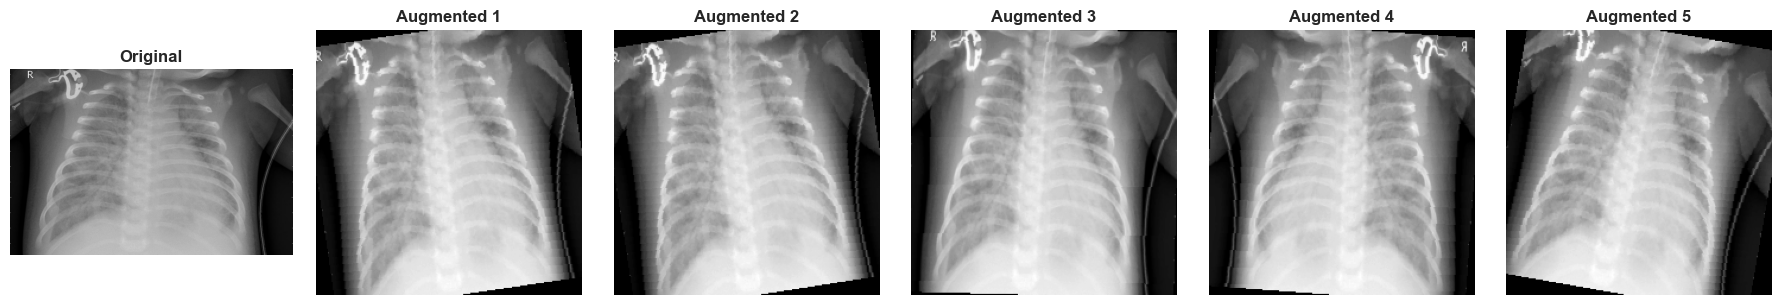

In [8]:
def show_augmentation_examples(image_path, transform, num_examples=5):
    """Show multiple augmented versions of the same image"""
    img = Image.open(image_path).convert('L')
    
    fig, axes = plt.subplots(1, num_examples + 1, figsize=(18, 3))
    
    # Original image
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original', fontweight='bold')
    axes[0].axis('off')
    
    # Augmented versions
    for i in range(1, num_examples + 1):
        augmented = transform(img)
        # Denormalize for visualization
        augmented = augmented * 0.5 + 0.5
        axes[i].imshow(augmented.squeeze(), cmap='gray')
        axes[i].set_title(f'Augmented {i}', fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('../reports/augmentation_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

# Get a sample image
sample_img_path = os.path.join(TRAIN_DIR, 'PNEUMONIA', 
                               os.listdir(os.path.join(TRAIN_DIR, 'PNEUMONIA'))[0])

print("Data Augmentation Examples:")
show_augmentation_examples(sample_img_path, train_transform, num_examples=5)

## 9. Create Custom PyTorch Dataset

In [9]:
class ChestXRayDataset(Dataset):
    """
    Custom PyTorch Dataset for Chest X-Ray images
    
    Args:
        root_dir: Path to train/test/val directory
        transform: Torchvision transforms to apply
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Load all image paths and labels
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            if not os.path.exists(class_path):
                continue
                
            for img_name in os.listdir(class_path):
                if img_name.endswith(('.jpeg', '.jpg', '.png')):
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(self.class_to_idx[class_name])
        
        print(f"Loaded {len(self.images)} images from {root_dir}")
        print(f"  NORMAL: {self.labels.count(0)}")
        print(f"  PNEUMONIA: {self.labels.count(1)}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Load image and convert to grayscale
        image = Image.open(img_path).convert('L')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

## 10. Create DataLoaders

In [10]:
# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 0  # Adjust based on your CPU

# Create datasets
print("Creating datasets...\n")
train_dataset = ChestXRayDataset(TRAIN_DIR, transform=train_transform)
print()
val_dataset = ChestXRayDataset(VAL_DIR, transform=val_test_transform)
print()
test_dataset = ChestXRayDataset(TEST_DIR, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {BATCH_SIZE}")

Creating datasets...

Loaded 5216 images from ..\data\train
  NORMAL: 1341
  PNEUMONIA: 3875

Loaded 16 images from ..\data\val
  NORMAL: 8
  PNEUMONIA: 8

Loaded 624 images from ..\data\test
  NORMAL: 234
  PNEUMONIA: 390

DataLoaders created:
  Train batches: 163
  Val batches: 1
  Test batches: 20
  Batch size: 32


## 11. Test DataLoader

Batch shape: torch.Size([32, 1, 224, 224])
Labels shape: torch.Size([32])
Image dtype: torch.float32
Labels: tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 1])
Image range: [-1.000, 1.000]

Sample batch from training set:


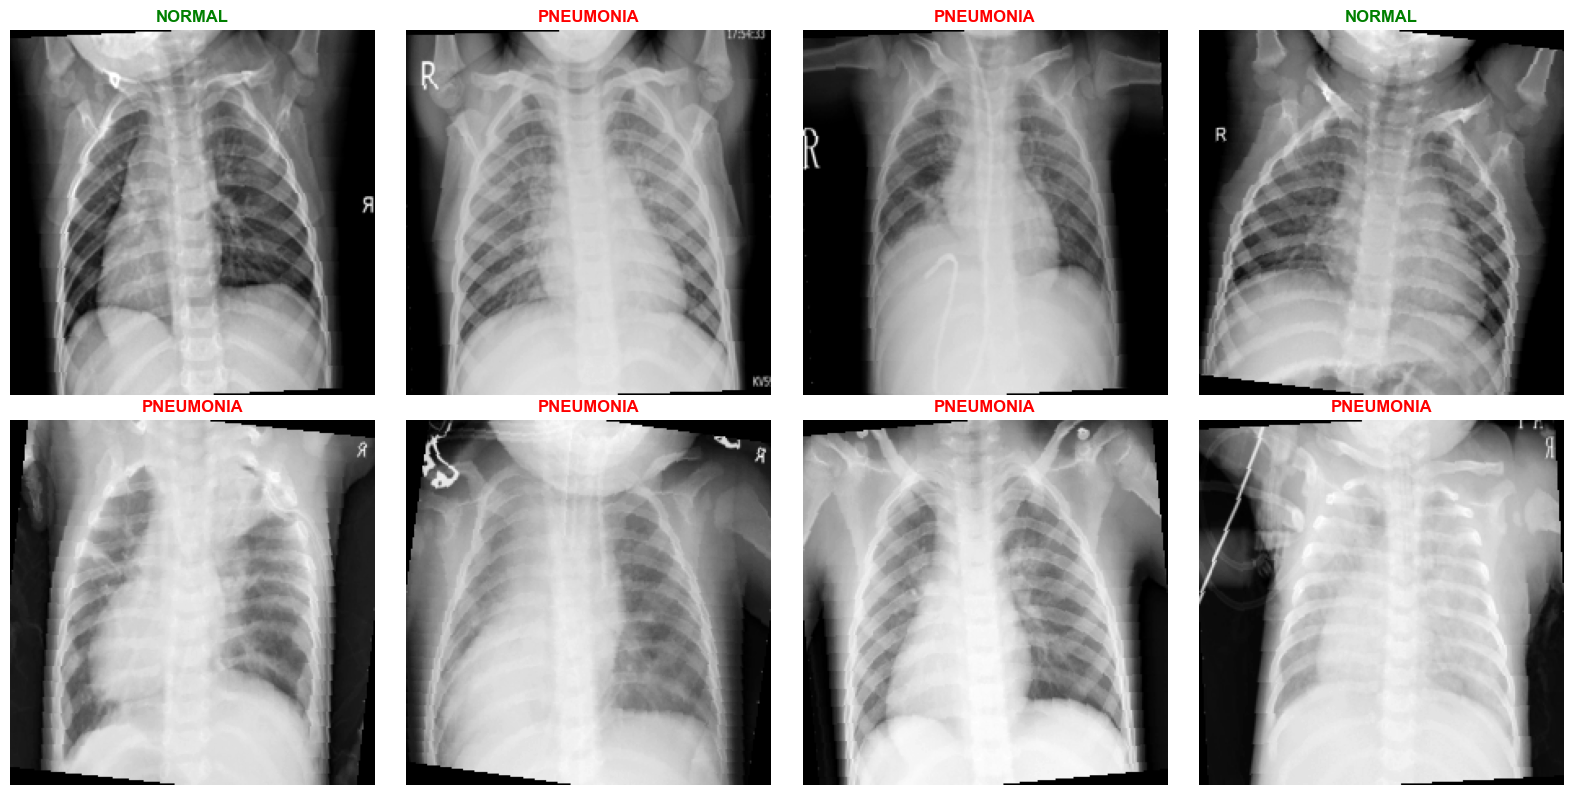

In [11]:
# Test the dataloader by fetching one batch
images, labels = next(iter(train_loader))

print(f"Batch shape: {images.shape}")  # Should be [batch_size, 1, 224, 224]
print(f"Labels shape: {labels.shape}")  # Should be [batch_size]
print(f"Image dtype: {images.dtype}")
print(f"Labels: {labels[:10]}")
print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")

# Visualize a batch
def show_batch(images, labels, num_images=8):
    """Display a batch of images with labels"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    class_names = ['NORMAL', 'PNEUMONIA']
    
    for i in range(num_images):
        # Denormalize image
        img = images[i] * 0.5 + 0.5
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f'{class_names[labels[i]]}', fontweight='bold', 
                         color='green' if labels[i] == 0 else 'red')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nSample batch from training set:")
show_batch(images, labels)

## 12. Summary and Next Steps

In [12]:
print("="*60)
print("PHASE 1 COMPLETE: Data Exploration & Preprocessing")
print("="*60)
print("\n✓ Dataset loaded and explored")
print("✓ Class distribution analyzed")
print("✓ Image properties examined")
print("✓ Preprocessing pipeline created")
print("✓ Data augmentation implemented")
print("✓ PyTorch DataLoaders ready")
print("\nKey Findings:")
print(f"  - Total images: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
print(f"  - Training images: {len(train_dataset)}")
print(f"  - Validation images: {len(val_dataset)}")
print(f"  - Test images: {len(test_dataset)}")
print(f"  - Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - Batch size: {BATCH_SIZE}")

PHASE 1 COMPLETE: Data Exploration & Preprocessing

✓ Dataset loaded and explored
✓ Class distribution analyzed
✓ Image properties examined
✓ Preprocessing pipeline created
✓ Data augmentation implemented
✓ PyTorch DataLoaders ready

Key Findings:
  - Total images: 5856
  - Training images: 5216
  - Validation images: 16
  - Test images: 624
  - Image size: 224x224
  - Batch size: 32
